In [35]:
import rescomp
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [34]:
# help(rescomp)
# help(rescomp.esn)

In [50]:
esn_normal = rescomp.esn.ESNWrapper()
esn_hybrid = rescomp.esn.ESNHybrid()

In [51]:
simulation_time_steps = 8000
dt = 2e-2

starting_point = np.array([-14.03020521, -20.88693127, 25.53545])
sim_data = rescomp.simulate_trajectory(
    sys_flag='lorenz', dt=dt, time_steps=simulation_time_steps,
    starting_point=starting_point)

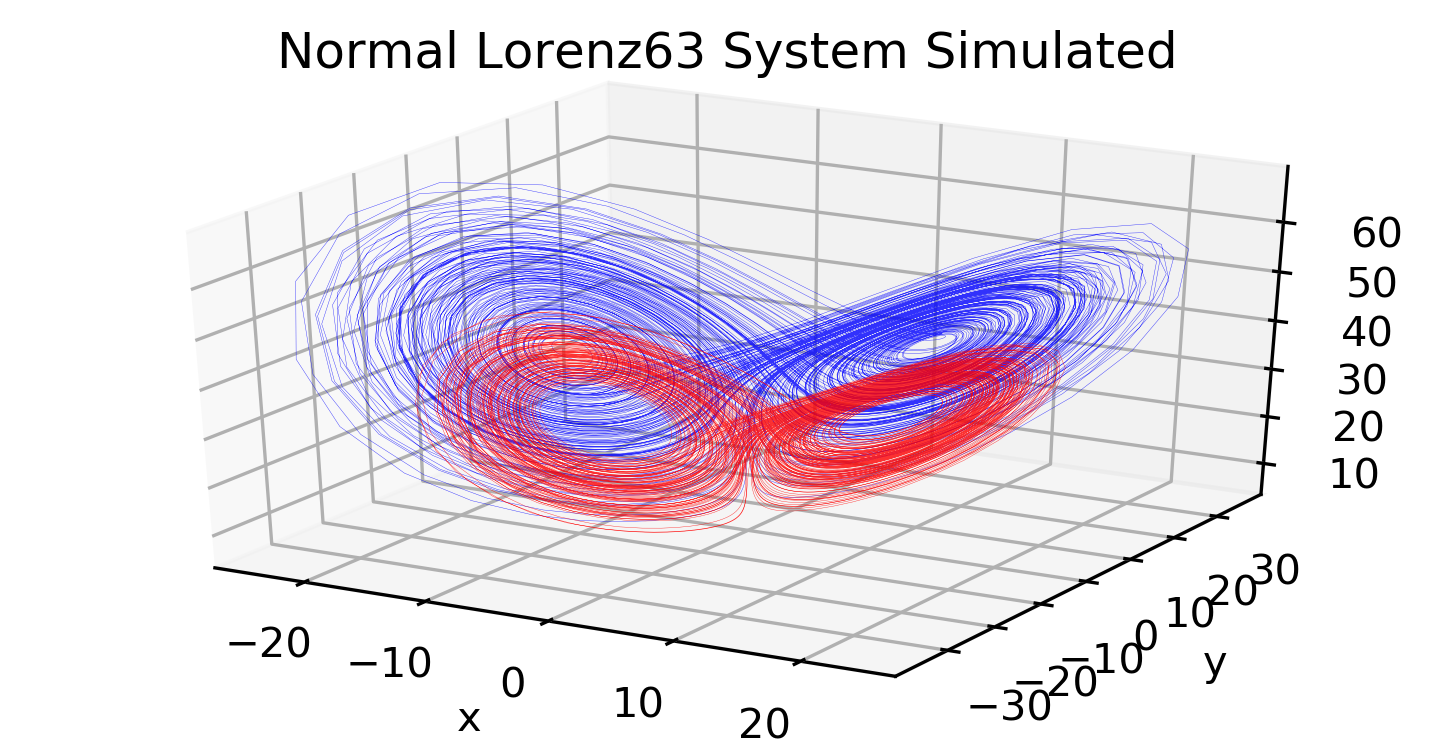

[[-14.03020521 -20.88693127  25.53545   ]
 [-15.6340354  -24.54740681  30.80196969]
 [-17.47563963 -26.6417367   37.51816639]
 [-19.15079895 -26.34735387  45.1198905 ]
 [-20.19789632 -23.1335749   52.3745277 ]] [[-14.03020521 -20.88693127  25.53545   ]
 [-15.25797688 -20.51030618  30.15606334]
 [-16.06372202 -18.7186594   34.62178262]
 [-16.27027628 -15.60166621  38.27016227]
 [-15.7840892  -11.61783523  40.55701638]]
(8000, 3) (8000, 3)


In [58]:
#Create artificially "wrong" model
eps1 = 0
eps2 = 0.5
eps3 = 0
model = lambda x: rescomp.simulations._normal_lorenz(x, sigma=10*(1+eps1), rho=28*(1+eps2), beta=8/3*(1+eps3))


# model = lambda x: -x

# model_pred = lambda x: x + model(x)*dt

model_pred = lambda x: rescomp.simulations._runge_kutta(model, dt, x)

# test it:
x = np.zeros((simulation_time_steps, 3))

x[0] = starting_point
for i in range(1, simulation_time_steps):
    x_i = x[i-1]
    x[i] = model_pred(x_i)
    
fig = plt.figure(figsize=(6, 3), dpi=300)
ax = fig.add_subplot(111, projection='3d')
ax.plot(x[:, 0], x[:, 1], x[:, 2],
        alpha=0.8, color='blue', linewidth = 0.1)
ax.plot(sim_data[:, 0], sim_data[:, 1], sim_data[:, 2],
        alpha=0.8, color='red', linewidth = 0.1)

# dif = sim_data - x
# ax.plot(dif[:, 0], dif[:, 1], dif[:, 2],
#         alpha=0.8, color='red', linewidth = 0.1)

ax.set_title("Normal Lorenz63 System Simulated")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

print(x[:5], sim_data[:5])

print(x.shape, sim_data.shape)

In [59]:
np.random.seed(1)

n_dim = 200

# normal model
esn_normal.create_network(n_dim = n_dim)

# hybrid model 
np.random.seed(1)
esn_hybrid.create_network(n_dim = n_dim)
add_model_to_input = True
gamma = 0.5
esn_hybrid.set_model(model_pred, add_model_to_input = add_model_to_input, gamma = gamma)

train_sync_steps = 400
train_steps = 4000
pred_steps = 1000  

In [60]:
# For testing different W_in settings
w_in_sparse=True #True
w_in_ordered=True #False
w_in_no_update=False #False
act_fct_flag='tanh_simple' #'tanh_simple'
w_out_fit_flag="simple" #"simple"

y_pred_normal, y_test_normal = esn_normal.train_and_predict(
    x_data=sim_data, train_sync_steps=train_sync_steps, train_steps=train_steps, 
    pred_steps=pred_steps, 
    w_in_sparse=w_in_sparse, w_in_ordered=w_in_ordered, w_in_no_update=w_in_no_update, act_fct_flag=act_fct_flag, 
    w_out_fit_flag=w_out_fit_flag
)

y_pred_hybrid, y_test_hybrid = esn_hybrid.train_and_predict(
    x_data=sim_data, train_sync_steps=train_sync_steps, train_steps=train_steps, 
    pred_steps=pred_steps, 
    w_in_sparse=w_in_sparse, w_in_ordered=w_in_ordered, w_in_no_update=w_in_no_update, act_fct_flag=act_fct_flag, 
    w_out_fit_flag=w_out_fit_flag
)

print(y_test_normal == y_test_hybrid)

print(esn_hybrid._w_in)

Actual percentage of Reservoir nodes connected to raw input:  50.0
xshape and model(x) shape:  (400, 3) (400, 3)
xshape after:  (400, 6)
win  shape:  (200, 6)
xshape and model(x) shape:  (3999, 3) (3999, 3)
xshape after:  (3999, 6)
win  shape:  (200, 6)
r_gen shape:  (3999, 200)
u_train shape:  (3999, 3)
[[ True  True  True]
 [ True  True  True]
 [ True  True  True]
 ...
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]]
[[-0.22527896  0.          0.          0.          0.          0.        ]
 [ 0.34018074  0.          0.          0.          0.          0.        ]
 [-0.59287924  0.          0.          0.          0.          0.        ]
 ...
 [ 0.          0.          0.          0.          0.          0.24190478]
 [ 0.          0.          0.          0.          0.         -0.73321194]
 [ 0.          0.          0.          0.          0.         -0.93418257]]


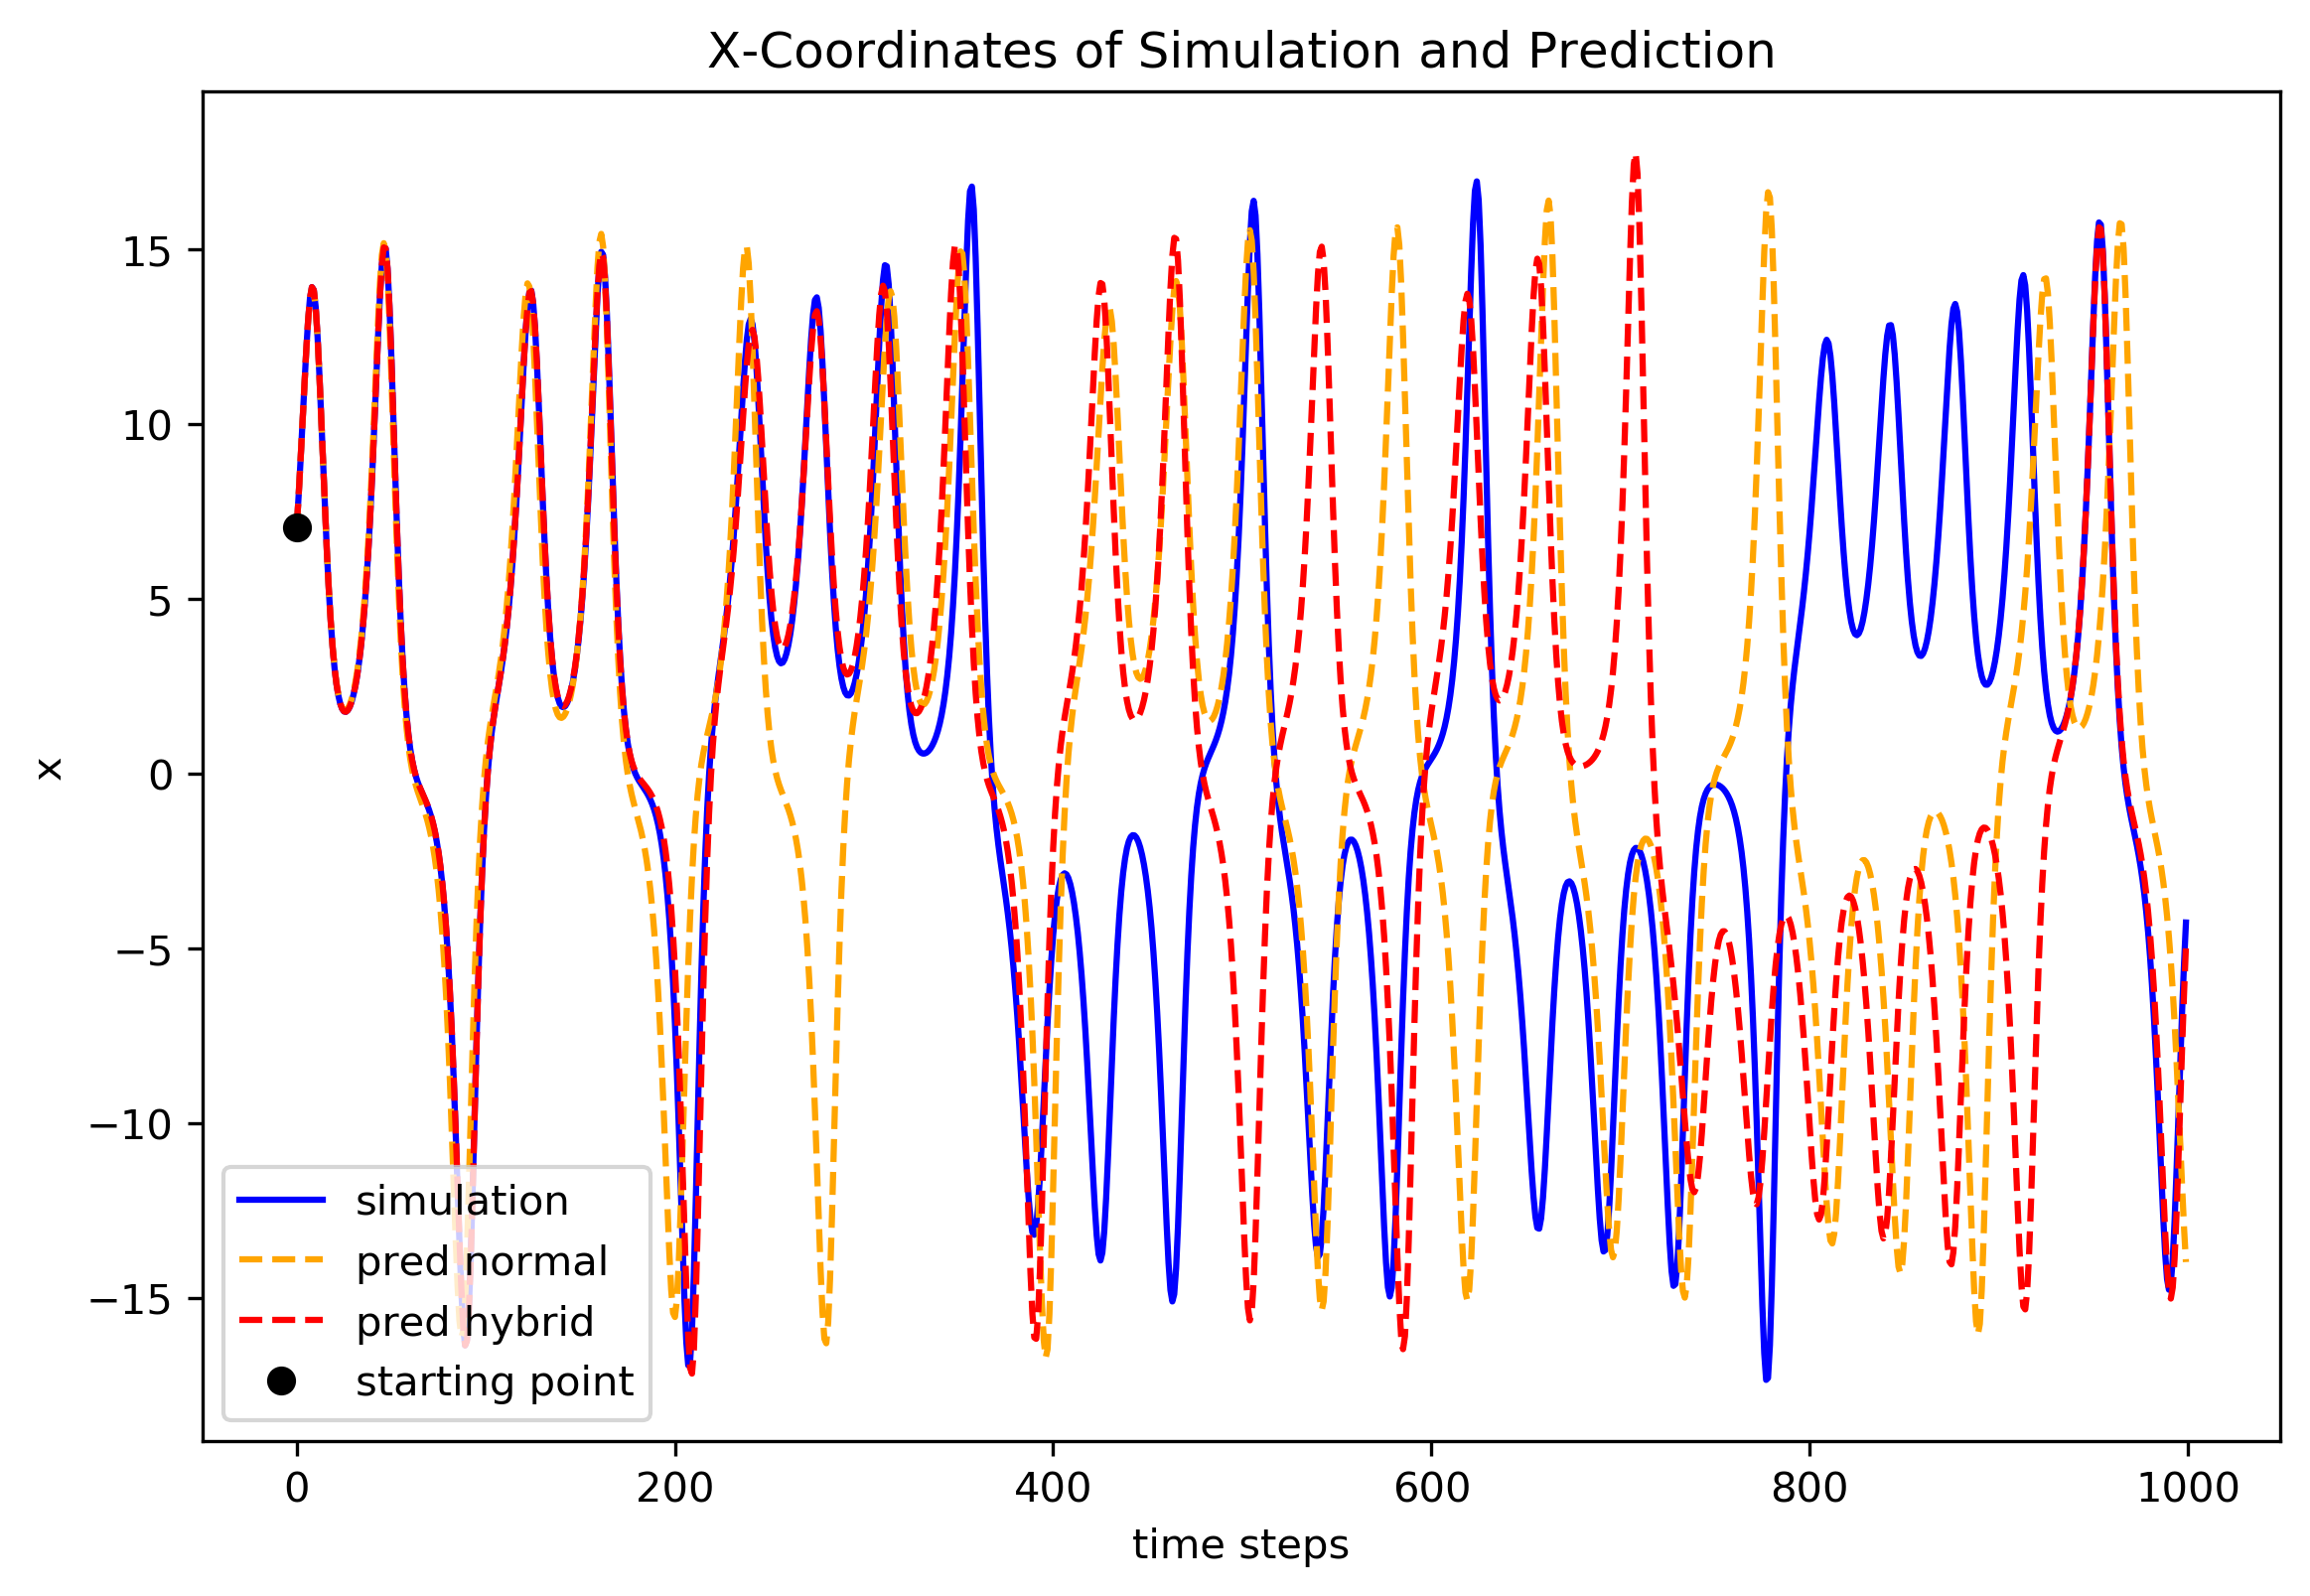

In [61]:
fig2 = plt.figure(figsize=(9, 6), dpi=300)
ax2 = fig2.add_subplot(1, 1, 1)
ax2.plot(y_test_normal[:, 0], color='blue', label='simulation')
ax2.plot(y_pred_normal[:, 0], color='orange', linestyle='--', label='pred normal')
ax2.plot(y_pred_hybrid[:, 0], color='red', linestyle='--', label='pred hybrid')


start = y_test_normal[0]
ax2.plot(start[0], color='black', linestyle='', marker='o', 
         label='starting point')

ax2.set_title("X-Coordinates of Simulation and Prediction")
ax2.set_xlabel('time steps')
ax2.set_ylabel('x')
plt.legend()
plt.show()

In [62]:
print(esn_hybrid._w_out.shape)
print(esn_normal._w_out.shape)

print(np.average(esn_hybrid._w_out[:, -3:]))
print(np.average(esn_hybrid._w_out[:, :-3]))

(3, 203)
(3, 200)
0.30684582804992405
-0.03083660074631742


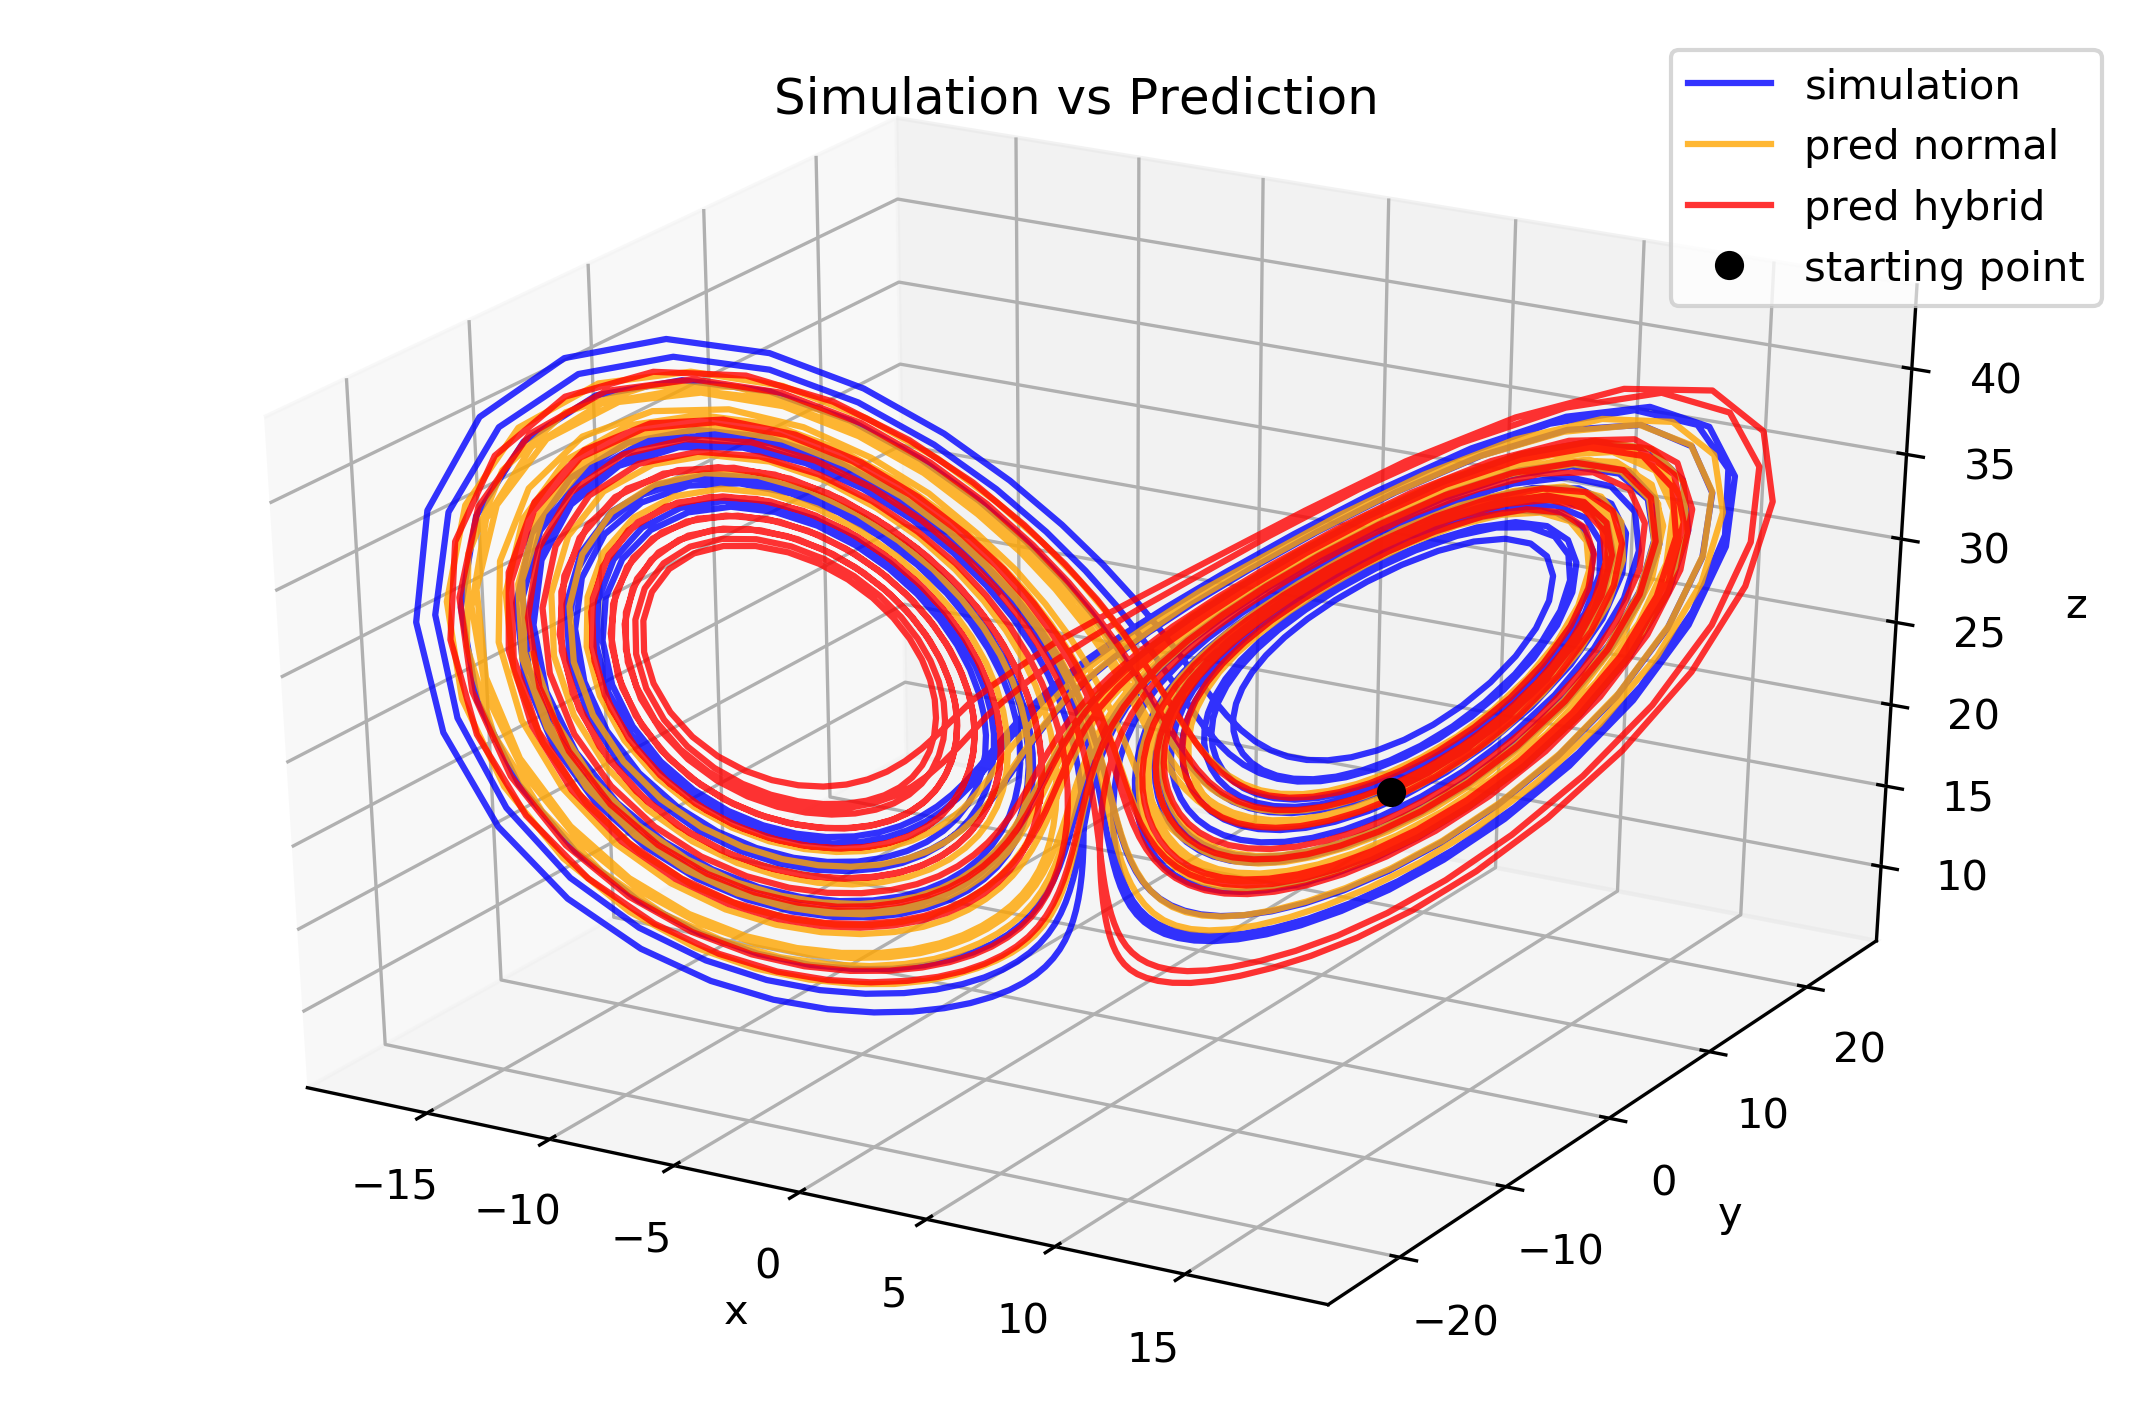

In [57]:
fig1 = plt.figure(figsize=(9, 6), dpi=300)
ax1 = fig1.add_subplot(111, projection='3d')

ax1.plot(y_test_normal[:, 0], y_test_normal[:, 1], y_test_normal[:, 2],
        alpha=0.8, color='blue', label='simulation')
ax1.plot(y_pred_normal[:, 0], y_pred_normal[:, 1], y_pred_normal[:, 2],
        alpha=0.8, color='orange', label='pred normal')
ax1.plot(y_pred_hybrid[:, 0], y_pred_hybrid[:, 1], y_pred_hybrid[:, 2],
        alpha=0.8, color='red', label='pred hybrid')

start = y_test_normal[0]
ax1.plot([start[0]], [start[1]], [start[2]], 
         color='black', linestyle='', marker='o', label='starting point')

ax1.set_title("Simulation vs Prediction")
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
plt.legend()
plt.show()